Joint Angles (degrees): (134.9751522417558, -151.87781754765865, 16.902665305902843)
Servo Angles (0-180 degrees): (-44.97515224175581, -61.87781754765865, -16.902665305902843)


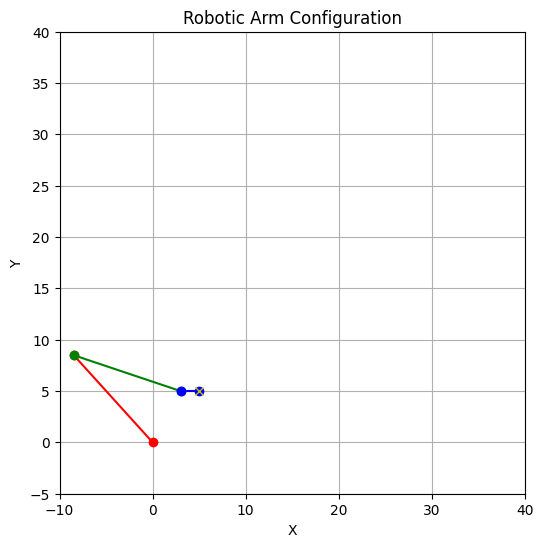

In [2]:
import numpy as np
import matplotlib.pyplot as plt


# Arm segment lengths
l1 = 12
l2 = 12
l3 = 2  # Length of the last segment

# Helper function to map angles to servo range
def map_to_servo_range(angle):
    # Map the angle (in degrees) to the servo range [0, 180]
    # Assuming -90 to 90 maps to 0 to 180 for the servo
    servo_angle = (angle + 90)  # Shift by 90 degrees to fit servo range
    return np.clip(servo_angle, 0, 180)

# Inverse Kinematics calculation
def inverse_kinematics(x, y):
    # Adjust the target to account for the horizontal third segment
    x_adj = x - l3  # Adjust for the third segment
    y_adj = y

    # Calculate the distance to the adjusted target
    r_adj = np.sqrt(x_adj**2 + y_adj**2)

    # Constrain the target to be within reach of the first two segments
    if r_adj > l1 + l2:
        scale = (l1 + l2) / r_adj
        x_adj *= scale
        y_adj *= scale

    # Calculate angles using the Law of Cosines
    cos_angle2 = (r_adj**2 - l1**2 - l2**2) / (2 * l1 * l2)
    angle2 = np.arccos(np.clip(cos_angle2, -1, 1))  # Angle at Joint 2

    k1 = l1 + l2 * np.cos(angle2)
    k2 = l2 * np.sin(angle2)
    angle1 = np.arctan2(y_adj, x_adj) - np.arctan2(k2, k1)

    # Calculate the position of Joint 2
    joint1_x, joint1_y = l1 * np.cos(angle1), l1 * np.sin(angle1)
    joint2_x = joint1_x + l2 * np.cos(angle1 + angle2)
    joint2_y = joint1_y + l2 * np.sin(angle1 + angle2)

    # Calculate the angle of the line between (0, 0) and (joint2_x, joint2_y)
    line_angle = np.arctan2(joint2_y, joint2_x)

    # Mirror the first and second segments along the imaginary line
    angle1 = 2 * line_angle - angle1
    angle2 = -angle2

    # Calculate the third segment's angle to make it horizontal
    angle3 = - (angle1 + angle2)

    # Convert angles to degrees
    angle1_deg = np.degrees(angle1)
    angle2_deg = np.degrees(angle2)
    angle3_deg = np.degrees(angle3)

    # Map the angles to the servo range [0, 180]
    servo_angle1 = 90-angle1_deg
    servo_angle2 = angle2_deg+90  # Relative adjustment for servo 2
    servo_angle3 = -(angle3_deg)  # Horizontal correction

    return angle1_deg, angle2_deg, angle3_deg, servo_angle1, servo_angle2, servo_angle3

# Test the inverse kinematics with a target position
target_x, target_y = 5,5
angles, servo_angles = inverse_kinematics(target_x, target_y)[:3], inverse_kinematics(target_x, target_y)[3:]
print("Joint Angles (degrees):", angles)
print("Servo Angles (0-180 degrees):", servo_angles)

def plot_arm(angles):
    angle1, angle2, angle3 = np.radians(angles)

    # Calculate joint positions
    joint1 = (l1 * np.cos(angle1), l1 * np.sin(angle1))
    joint2 = (joint1[0] + l2 * np.cos(angle1 + angle2), joint1[1] + l2 * np.sin(angle1 + angle2))
    effector = (joint2[0] + l3 * np.cos(angle1 + angle2 + angle3), joint2[1] + l3 * np.sin(angle1 + angle2 + angle3))

    # Plot base, joints, and links
    plt.figure(figsize=(6, 6))
    plt.plot([0, joint1[0]], [0, joint1[1]], 'ro-')  # Base to Joint 1
    plt.plot([joint1[0], joint2[0]], [joint1[1], joint2[1]], 'go-')  # Joint 1 to Joint 2
    plt.plot([joint2[0], effector[0]], [joint2[1], effector[1]], 'bo-')  # Joint 2 to effector
    plt.plot(target_x, target_y, 'yx')  # Target position

    # Plot configuration
    plt.xlim(-10,40)
    plt.ylim(-5, 40)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Robotic Arm Configuration')
    plt.grid(True)
    plt.show()

plot_arm(angles)


In [1]:
import numpy as np

def compute_servo_angles(l1, l2, l3, x, y):
    """
    Computes the joint angles and servo angles for a robotic arm.
    
    Parameters:
        l1 (float): Length of the first segment.
        l2 (float): Length of the second segment.
        l3 (float): Length of the third segment.
        x (float): Target x-coordinate of the endpoint.
        y (float): Target y-coordinate of the endpoint.
    
    Returns:
        tuple: (joint_angles, servo_angles)
            - joint_angles: A tuple of (angle1, angle2, angle3) in degrees.
            - servo_angles: A tuple of (servo_angle1, servo_angle2, servo_angle3) in the range [0, 180].
    """
    def map_to_servo_range(angle):
        # Map the angle (in degrees) to the servo range [0, 180]
        return np.clip(angle + 90, 0, 180)

    # Adjust the target to account for the horizontal third segment
    x_adj = x - l3  # Adjust for the third segment
    y_adj = y

    # Calculate the distance to the adjusted target
    r_adj = np.sqrt(x_adj**2 + y_adj**2)

    # Constrain the target to be within reach of the first two segments
    if r_adj > l1 + l2:
        scale = (l1 + l2) / r_adj
        x_adj *= scale
        y_adj *= scale

    # Calculate angles using the Law of Cosines
    cos_angle2 = (r_adj**2 - l1**2 - l2**2) / (2 * l1 * l2)
    angle2 = np.arccos(np.clip(cos_angle2, -1, 1))  # Angle at Joint 2

    k1 = l1 + l2 * np.cos(angle2)
    k2 = l2 * np.sin(angle2)
    angle1 = np.arctan2(y_adj, x_adj) - np.arctan2(k2, k1)

    # Calculate the angle of the line between (0, 0) and the adjusted joint2
    joint1_x, joint1_y = l1 * np.cos(angle1), l1 * np.sin(angle1)
    joint2_x = joint1_x + l2 * np.cos(angle1 + angle2)
    joint2_y = joint1_y + l2 * np.sin(angle1 + angle2)
    line_angle = np.arctan2(joint2_y, joint2_x)

    # Mirror the first and second segments along the imaginary line
    angle1 = 2 * line_angle - angle1
    angle2 = -angle2

    # Calculate the third segment's angle to make it horizontal
    angle3 = - (angle1 + angle2)

    # Convert angles to degrees
    angle1_deg = np.degrees(angle1)
    angle2_deg = np.degrees(angle2)
    angle3_deg = np.degrees(angle3)

    # Map the angles to the servo range [0, 180]
    servo_angle1 = map_to_servo_range(angle1_deg)
    servo_angle2 = map_to_servo_range(angle1_deg + angle2_deg)  # Relative adjustment for servo 2
    servo_angle3 = map_to_servo_range(0)  # Third segment always horizontal

    joint_angles = (angle1_deg, angle2_deg, angle3_deg)
    servo_angles = (servo_angle1, servo_angle2, servo_angle3)

    return joint_angles, servo_angles